In [9]:
# Data: time-serie data from smartwatch or smartwatch data
# %matplotlib inline # for plt.show()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
# data_path = 'data/financial_data/USD_INR.csv'
data_path = 'data/bike_data/hour.csv'
data = pd.read_csv(data_path)

# Data: cleaning
# Getting rid of NaN
data = data.fillna(value=0.0)

# Showing the data file csv or comma separated value
data[:10]

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   
5        6  2011-01-01       1   0     1   5        0        6           0   
6        7  2011-01-01       1   0     1   6        0        6           0   
7        8  2011-01-01       1   0     1   7        0        6           0   
8        9  2011-01-01       1   0     1   8        0        6           0   
9       10  2011-01-01       1   0     1   9        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81     0.0000       3          13   16  
1           1  0.22  0.2727  0.80     0.0000       8          32   40  
2           1  0.22  0.2727  0.80     0.0000       5          27   32  
3           1  0.24  0.2879  0.75     0.0000       3          10   13  
4           1  0.24  0.2879  0.75     0.0000       0           1    1  
5           2  0.24  0.2576  0.75     0.0896       0           1    1  
6           1  0.22  0.2727  0.80     0.0000       2           0    2  
7           1  0.20  0.2576  0.86     0.0000       1           2    3  
8           1  0.24  0.2879  0.75     0.0000       1           7    8  
9           1  0.32  0.3485  0.76     0.0000       8           6   14

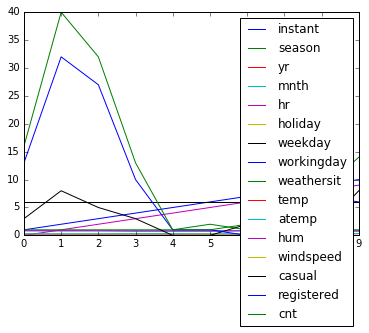

In [10]:
# # Plotting the smartwatch data before scaling/batch normalization
# data[:10000]['Price'].plot()
data[: 10].plot()
plt.legend()
plt.show()

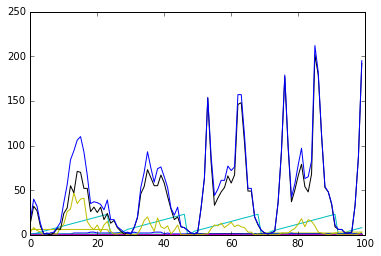

In [11]:
data_array = np.array(data)
data_array.shape, data_array.dtype
data_main = np.array(data_array[:, 2:], dtype=float)
data_main.shape, data_main.dtype

plt.plot(data_main[:100])
plt.show()

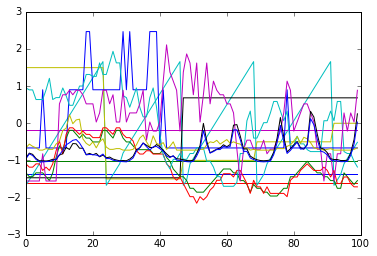

(-2.0933188371550222e-17,
 0.99999999999999978,
 0.99999999999999967,
 (17379, 15),
 dtype('float64'))

In [12]:
mean = np.mean(data_main, axis=0)
std = np.std(data_main, axis=0)
std.shape, mean.shape, std.dtype, mean.dtype

data_norm = (data_main - mean) / std
plt.plot(data_norm[:100])
plt.show()
data_norm.mean(), data_norm.std(), data_norm.var(), data_norm.shape, data_norm.dtype

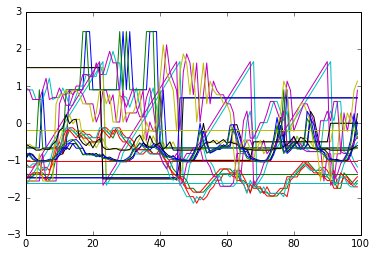

In [13]:
train_data = data_norm[:16000] # the last dim/variable/feature
test_data = data_norm[16000:] # the last dim/variable/feature
train_data.shape, test_data.shape
X_train = train_data[0:15999]
Y_train = train_data[1:16000]
X_train.shape, Y_train.shape

plt.plot(X_train[:100])
plt.plot(Y_train[:100])
plt.show()

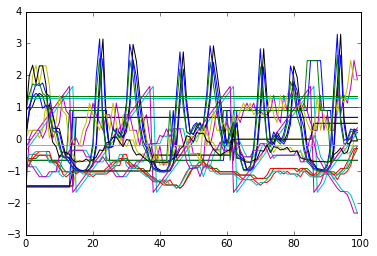

In [14]:
X_valid = test_data[0:1378] 
Y_valid = test_data[1:1379]
X_valid.shape, Y_valid.shape
plt.plot(X_valid[:100])
plt.plot(Y_valid[:100])
plt.show()

In [15]:
def get_im2col_indices(X_shape, field_height, field_width, padding=1, stride=1):
    # First figure out what the size of the output should be
    # Input shape
    N, C, H, W = X_shape
    
    # Kernel shape
    # field_height, field_width = kernel_shape
    field_C = C
    
    # X_txn, t = H, n = W
    p_H = padding
    p_W = padding
    
    # Output shape
    assert (H + (2 * p_H) - field_height) % stride == 0
    assert (W + (2 * p_W) - field_width) % stride == 0
    out_height = int(((H + (2 * p_H) - field_height) / stride) + 1)
    out_width = int(((W + (2 * p_W) - field_width) / stride) + 1)
    out_C = 1 # the output channel/ depth
#     print('out_height, out_width', out_height, out_width)

    # Row, Height, i
    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, field_C)
    i1 = np.repeat(np.arange(out_height), out_width)
    i1 = np.tile(i1, out_C)
    i1 *= stride
    
    # Column, Width, j
    j0 = np.tile(np.arange(field_width), field_height * field_C)
    j1 = np.tile(np.arange(out_width), out_height * out_C)
    j1 *= stride
    
    # Channel, Depth, K
    k0 = np.repeat(np.arange(field_C), field_height * field_width) #.reshape(-1, 1) # out_C = 1
    k1 = np.repeat(np.arange(out_C), out_height * out_width) #.reshape(-1, 1) # out_C = 1
    k1 *= stride
    
    # Indices: i, j, k index
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)
    k = k0.reshape(-1, 1) + k1.reshape(1, -1)
    
#     print('i.shape, j.shape, k.shape', i.shape, j.shape, k.shape)
    return (k.astype(int), i.astype(int), j.astype(int))

def im2col_indices(X, field_height, field_width, padding=1, stride=1):
    """ An implementation of im2col based on some fancy indexing """
    # Zero-pad the input
    # X_txn, t = H, n = W
    p_H = padding
    p_W = padding
    X_padded = np.pad(X, ((0, 0), (0, 0), (p_H, p_H), (p_W, p_W)), mode='constant') # X_NxCxHxW

    k, i, j = get_im2col_indices(X.shape, field_height, field_width, padding, stride)

    X_col = X_padded[:, k, i, j] # X_col_txkxn
    
    N, C, H, W = X.shape
    
    # field_height, field_width = kernel_shape
    field_C = C # x.shape[1]
    kernel_size = field_C * field_height * field_width
    
    X_col = X_col.transpose(1, 2, 0).reshape(kernel_size, -1)
    
    return X_col

def col2im_indices(X_col, X_shape, field_height=3, field_width=3, padding=1, stride=1):
    """ An implementation of col2im based on fancy indexing and np.add.at """
    N, C, H, W = X_shape
    p_H = padding
    p_W = padding
    H_padded, W_padded = H + (2 * p_H), W + (2 * p_W)
    X_padded = np.zeros((N, C, H_padded, W_padded), dtype=X_col.dtype)
    
    k, i, j = get_im2col_indices(X_shape, field_height, field_width, padding, stride)

    # field_height, field_width = kernel_shape
    field_C = C # x.shape[1]
    kernel_size = field_C * field_height * field_width

    X_col = X_col.reshape(kernel_size, -1, N).transpose(2, 0, 1) # N, K, H * W
#     print('X_col.shape', X_col.shape)
    
    np.add.at(X_padded, (slice(None), k, i, j), X_col) # slice(None)== ':'
    
#     print('X_padded.shape', X_padded.shape)
    if padding > 0:
        X_padded = X_padded[:, :, padding:-padding, padding:-padding]
#     print('X_padded.shape', X_padded.shape)
    
    return X_padded

def conv_forward(X, W, b, stride=1, padding=0):
    cache = W, b, stride, padding
    
    # Input X
    n_x, d_x, h_x, w_x = X.shape
    
    # Kernel W
    n_filter, d_filter, h_filter, w_filter = W.shape
    
    # Output
    p_H = padding
    p_W = padding
    h_out = ((h_x + (2 * p_H) - h_filter) / stride) + 1
    w_out = ((w_x + (2 * p_W) - w_filter) / stride) + 1

    if not h_out.is_integer() or not w_out.is_integer():
        raise Exception('Invalid output dimension!')

    h_out, w_out = int(h_out), int(w_out)

    X_col = im2col_indices(X, h_filter, w_filter, padding=padding, stride=stride)
    W_col = W.reshape(n_filter, -1)

    out = (W_col @ X_col) + b
    out = out.reshape(n_filter, h_out, w_out, n_x).transpose(3, 0, 1, 2)
    cache = (X, W, b, stride, padding, X_col)

    return out, cache

def conv_backward(dout, cache):
    X, W, b, stride, padding, X_col = cache
    n_filter, d_filter, h_filter, w_filter = W.shape
    
#     print('dout.shape', dout.shape)

    db = np.sum(dout, axis=(0, 2, 3))
    db = db.reshape(n_filter, -1)

    dout = dout.transpose(1, 2, 3, 0).reshape(n_filter, -1)
    dW = dout @ X_col.T
    dW = dW.reshape(W.shape)

    W = W.reshape(n_filter, -1)
    dX_col = W.T @ dout
    dX = col2im_indices(dX_col, X.shape, h_filter, w_filter, padding=padding, stride=stride)

    return dX, dW, db

# Pre-processing
def prepro(X_train, X_val, X_test):
    mean = np.mean(X_train)
    # scale = 255. - mean # std or sqrt(var), 255 == 2**8 or 8 bit grayscale
    # return (X_train - mean)/ scale, (X_val - mean)/ scale, (X_test - mean) / scale
    return X_train - mean, X_val - mean, X_test - mean

def selu_forward(X):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
    cache = X
    return out, cache

def selu_backward(dout, cache):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    X = cache
    dX_pos = dout.copy()
    dX_pos[X<0] = 0
    dX_neg = dout.copy()
    dX_neg[X>0] = 0
    dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
    return dX

# p_dropout = keep_prob in this case. 
# Is this true in other cases as well? Yes.
def selu_dropout_forward(h, q):
    '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    alpha_p = -scale * alpha
    mask = np.random.binomial(1, q, size=h.shape)
    dropped = (mask * h) + ((1 - mask) * alpha_p)
    a = 1. / np.sqrt(q + (alpha_p ** 2 * q  * (1 - q)))
    b = -a * (1 - q) * alpha_p
    out = (a * dropped) + b
    cache = (a, mask)
    return out, cache

def selu_dropout_backward(dout, cache):
    a, mask = cache
    d_dropped = dout * a
    dh = d_dropped * mask
    return dh

In [16]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class CNN:

    def __init__(self, D, H, L, p_dropout, mb_size):
#         self.mode = 'regression'
        self.L = L # number of layers or depth
        self.p_dropout = p_dropout
        self.losses = {'train':[], 'smooth train':[], 'valid':[]}
        self.model = [] # model params: w and b
        
        # Model parameters: weights and biases
        # Input layer of Conv - X_txn: t== height, n == D
        # No padding in this layer
        # kernel_kNxkCxkHxkW
        kN = H # number of kernel units/ neurons  
        kC = 1 # kernel channels/depth == input channel == X_NxCxHxW == this is C == stack of images or minibatches
        kH = mb_size # kernel height = time
        kW = D # kernel with = input width = dim/ features/ channels
        kernel_size = kC * kH * kW # number of synapses of the kernels
        m = dict(
            W1=np.random.randn(kN, kC, kH, kW) / np.sqrt(kC * kH * kW / 2.), # W_NCHW in this fashion
            b1=np.zeros((kN, 1))
        )
        self.model.append(m) # self.model[0][L]
        
        # Hidden layers of Conv-bn-relu-dropout
        # No padding also in this layer since H & W are both 1
        kN = H # number of kernel units/ neurons  
        kC = H # kernel channels/depth == input channel
        kH = 1 # kernel height
        kW = 1 # kernel with = input width
        m = dict(
            W2=np.random.randn(kN, kC, kH, kW) / np.sqrt(kC * kH * kW / 2.), # W_NCHW in this fashion
            b2=np.zeros((kN, 1))
        )
        m_L = [] # for all layers: L
        for _ in range(self.L):
            m_L.append(m)
        self.model.append(m_L) # self.model[1][L]
        
        # Output layer of FC to output: FFNN -  can be replace by RNN
        m = dict(
            W3=np.random.randn(H, D) / np.sqrt(H/ 2.), # W_NCHW in this fashion
            b3=np.zeros((1, D))
        )
        self.model.append(m) # self.model[2][L]

    def forward(self, X, train):
        
        # Preprocessing: reshaping X_txn to X_1x1xtxn 
        X = X.reshape(1, 1, *X.shape) # X_1x1xtxn
#         print('X.shape', X.shape)
        
        # 1st layer - Input layer: X
        X, X_conv_cache = conv_forward(X=X, W=self.model[0]['W1'], b=self.model[0]['b1'])
        X_cache = X_conv_cache
#         print('X.shape', X.shape)

        # 2nd layers - Hidden layers: h
        h_cache = []
        for layer in range(self.L):
            h, h_conv_cache = conv_forward(X=X, W=self.model[1][layer]['W2'], b=self.model[1][layer]['b2'])
            h, h_nl_cache = selu_forward(X=h)
#             h += X # residual connection
            if train: 
                # h_do_cache = None # ERROR: referenced before assigned?
                h, h_do_cache = selu_dropout_forward(h=h, q=self.p_dropout)
                cache = (h_conv_cache, h_nl_cache, h_do_cache)
            else:
                cache = (h_conv_cache, h_nl_cache)
            h_cache.append(cache)
#         print('h.shape', h.shape)
            
        # 3rd layer - Output layer: y
        y = h.reshape([X.shape[0], -1]) # flattening
#         print('y.shape', y.shape)        
        y, y_fc_cache = l.fc_forward(X=y, W=self.model[2]['W3'], b=self.model[2]['b3']) # y_1xn
        y_cache = X, y_fc_cache
#         print('y.shape', y.shape)        

        cache = (X_cache, h_cache, y_cache)
        
        return y, cache

    def loss_function(self, y_pred, y_train):
        loss = l2_regression(y_pred=y_pred, y_train=y_train)
        dy = dl2_regression(y_pred=y_pred, y_train=y_train)
        return loss, dy
        
    def backward(self, dy, cache):
        X_cache, h_cache, y_cache = cache
#         print('dy.shape', dy.shape)
        dy = dy.reshape(1, -1)
#         print('dy.shape', dy.shape)


        # 3rd layer: Ouput layer y
        X, y_fc_cache = y_cache
        dy, dw3, db3 = l.fc_backward(dout=dy, cache=y_fc_cache)
#         print('dy.shape', dy.shape)
        dy = dy.reshape([-1, *X.shape[1:4]])
#         print('dy.shape', dy.shape)
        
        # 2nd layers: Hidden layers h
        g = []
        for layer in reversed(range(self.L)):
            # if train: There is no backward in testing/prediction
            h_conv_cache, h_nl_cache, h_do_cache = h_cache[layer]
            dy = selu_dropout_backward(dout=dy, cache=h_do_cache)
            dh = selu_backward(dout=dy, cache=h_nl_cache)
            dh, dw2, db2 = conv_backward(dout=dh, cache=h_conv_cache)
#             dh += dy
            g.append(dict(
                    W2=dw2,
                    b2=db2
                    ))
            
        # 1st layer: Input layer X
        X_conv_cache = X_cache
        dX, dw1, db1 = conv_backward(dout=dh, cache=X_conv_cache)
        # dX: TODO: hast not been used but this basically should be 0 
        # which means input can be perfectly recontructed!
        # dX is the grad_input or delta for input or the calculated error or difference or delta
        # Can be used as noise which is because it is unwanted and can be added to data to be calculated again
        # when the data is not abundantly available!
        
        # Not need at the moment
        # Preprocessing: reshaping X_txn to X_1x1xtxn 
        # dX = dX.reshape(*X.shape)


        # grad for GD
        grad = []
        
        # Input layer to conv layer
        grad.append(dict(
            W1=dw1, 
            b1=db1
        ))
        
        # Hidden layers of conv-bn-nl/relu-dropout/do
        grad.append(g)
        
        # Output later to FC layer
        grad.append(dict(
            W3=dw3, 
            b3=db3
        ))
        
        return dX, grad
    
    def test(self, X_seed, size):
        ys = []
        
        for t in range(size):
            y, _ = self.forward(X_seed, train=False) # y_1xn, X_txn
#             print('y.shape, X.shape', y.shape, X.shape)
            X = np.row_stack((X_seed, y)) # X_(t+1)xn
#             print('X.shape', X.shape)
            X_seed = X[1:]
#             print('X.shape', X.shape)
            ys.append(y) # ys_tx1xn
            
        y_pred = np.array(ys, dtype=float).reshape(size, -1) # ys_txn
#         print('y_pred.shape', y_pred.shape)
        return y_pred
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        num_mb = X.shape[0]// minibatch_size
        for i in range(num_mb):
            X_mini = X[(i * minibatch_size): ((i + 1) * minibatch_size)]
#             y_mini = y[i:i + minibatch_size]
            y_mini = y[(((i + 1) * minibatch_size) -1) : ((i + 1) * minibatch_size)] # y_1xn
            minibatches.append((X_mini, y_mini))

#         for i in range(0, X.shape[0], minibatch_size):
#             X_mini = X[i:i + minibatch_size]
# #             y_mini = y[i:i + minibatch_size]
#             y_mini = y[i + minibatch_size - 1 :i + minibatch_size] # y_1xn
#             minibatches.append((X_mini, y_mini))

# #          This is very time-consuming
#         for i in range(0, X.shape[0] - minibatch_size + 1, 1):
#             X_mini = X[i:i + minibatch_size] # X_txn
#             y_mini = y[i + minibatch_size - 1 :i + minibatch_size] # y_1xn
#             minibatches.append((X_mini, y_mini))

        return minibatches

    def adam(self, train_set, valid_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        # if val_set: # tuple NOT tensor
        X_val, y_val = valid_set

        # Momentum variables
        # Input: CNN
        M, R = [], []
        M.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden: CNN
        M_, R_ = [], []
        for layer in range(self.L):
            M_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
            R_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        M.append(M_)
        R.append(R_)
        
        # Output: FC or FFNN
        M.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[2].items()})

        # Learning decay
        beta1 = .9
        beta2 = .99
        smooth_train = 1.

        # Extracting the minibatches
        minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=False) # seq data needs no shuffle
        #         minibatches_valid = self.get_minibatch(X_val, y_val, mb_size, shuffle=False) # seq data needs no shuffle
        #         X_val_seed, _ = minibatches_valid[0]
        # if val_set:
        valid_size = y_val.shape[0] # y_txn
        X_val_seed = X_val[:mb_size]
#         y_val = y_val[:200]

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            for idx in range(len(minibatches)):
                
                # Train the model
                X_mini, y_mini = minibatches[idx]
#                 print('X_mini.shape, y_mini.shape', X_mini.shape, y_mini.shape)
                y, cache = self.forward(X_mini, train=True)
                loss, dy = self.loss_function(y, y_mini)
                _, grad = self.backward(dy, cache)
                self.losses['train'].append(loss)
                smooth_train = (0.999 * smooth_train) + (0.001 * loss)
                self.losses['smooth train'].append(smooth_train)

                # Update the model: input layer
                for key in grad[0].keys():
                    M[0][key] = l.exp_running_avg(M[0][key], grad[0][key], beta1)
                    R[0][key] = l.exp_running_avg(R[0][key], grad[0][key]**2, beta2)

                    m_k_hat = M[0][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[0][key] / (1. - (beta2**(iter)))

                    self.model[0][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

                # Update the model: hidden layers
                for layer in range(self.L):
                    for key in grad[1][layer].keys():
                        M[1][layer][key] = l.exp_running_avg(M[1][layer][key], grad[1][layer][key], beta1)
                        R[1][layer][key] = l.exp_running_avg(R[1][layer][key], grad[1][layer][key]**2, beta2)

                        m_k_hat = M[1][layer][key] / (1. - (beta1**(iter)))
                        r_k_hat = R[1][layer][key] / (1. - (beta2**(iter)))

                        self.model[1][layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)
                        
                # Update the model: output layer
                for key in grad[2].keys():
                    M[2][key] = l.exp_running_avg(M[2][key], grad[2][key], beta1)
                    R[2][key] = l.exp_running_avg(R[2][key], grad[2][key]**2, beta2)

                    m_k_hat = M[2][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[2][key] / (1. - (beta2**(iter)))

                    self.model[2][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

                # Validate the model by testing OR
                # Test the model
                # Test the updated model to validate the model
                # Avoid overfitting/ memorizing and underfitting lack of model capacity
                y_pred = self.test(X_val_seed, size=valid_size)
#                 print('y_pred.shape, y_val.shape', y_pred.shape, y_val.shape)
                valid_loss, _ = self.loss_function(y_pred, y_val) # softmax is included in entropy loss function
                self.losses['valid'].append(valid_loss)

            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}'.format(iter, loss, valid_loss))

In [ ]:
# Hyper-parameters
n_iter = 10 # number of epochs
alpha = 1e-4 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
num_layers = 10 # depth 
print_after = 1 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 8 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
# num_output_units = X_ # number of classes in this classification problem
p_dropout = 0.95 #  layer & unit noise: keep_prob = p_dropout, q = 1-p, 0.95 or 0.90 by default, noise at the network level or layers

# Build the model/NN and learn it: running session.
nn = CNN(D=num_input_units, H=num_hidden_units, p_dropout=p_dropout, L=num_layers, mb_size=mb_size)

nn.adam(train_set=(X_train, Y_train), valid_set=(X_valid, Y_valid), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel_launcher.py:153: RuntimeWarning: overflow encountered in exp
/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel_launcher.py:153: RuntimeWarning: overflow encountered in multiply


Iter-1 train loss: 25.9659 valid loss: 28548984243796819591561216.0000
Iter-2 train loss: 15.0739 valid loss: 554654147347041233326309376.0000
Iter-3 train loss: 13.6945 valid loss: 3055847173605503795200.0000
Iter-4 train loss: 13.2402 valid loss: 2746811011831027712.0000


In [ ]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

# plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

In [ ]:
loss_train = np.array(nn.losses['train'], dtype=float)
loss_train.shape, loss_train.dtype
mean = np.mean(loss_train, axis=0)
std = np.std(loss_train, axis=0)
std.shape, mean.shape, std.dtype, mean.dtype

loss_train_norm = (loss_train - mean) / std
loss_train_norm.shape, loss_train_norm.dtype
plt.plot(loss_train_norm, label='Train loss normalized')
# plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

In [ ]:
y_pred = nn.test(X_valid[:mb_size], size=X_valid.shape[0])
#                 print('y_pred.shape, y_val.shape', y_pred.shape, y_val.shape)
# valid_loss, _ = self.loss_function(y_pred, y_val) # softmax is included in entropy loss function

y_pred.shape

plt.plot(y_pred[100:200, -1], label='y_pred')
plt.plot(Y_valid[100:200, -1], label='Y_valid')
plt.legend()
plt.show()